# 파이토치 입문

## 2. 인공신경망

### (1) 다층 퍼셉트론

#### 1) 선형회귀

In [3]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [4]:
x = torch.FloatTensor(range(5))
x

tensor([0., 1., 2., 3., 4.])

In [5]:
x = torch.FloatTensor(range(5)).unsqueeze(1)
x

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])

In [6]:
y = 2*x + torch.rand(5, 1)  # (5, 1) size의 텐서를 만들어 준다. 
y

tensor([[0.0606],
        [2.1943],
        [4.7909],
        [6.0517],
        [8.5523]])

In [7]:
# 신경망 정의

class LinearRegressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델을 정의 할때는 nn.Moduel을 상속받아 정의한다. 
        self.fc=nn.Linear(1, 1, bias=True)  # 선형회귀 모델 y=wx+b는 nn.Linear(N, N, bias=True)로 표현 할 수 있으며, N은 입력변수의 개수, M은 출력변수의 개수

    def forward(self, x): # forward함수는 실제 입력값이 들어와서 연산이 진행되는 순서와 방법을 정하는 곳이다. 
        y = self.fc(x)

        return y

In [8]:
model = LinearRegressor() # 모델 선언
learning_rate = 1e-3
criterion = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 최적화 방법 결정후 파라미터를 gradient descent 하기 위해서는 model.parameters()라는 argument를 넣어줘야 한다. 

In [9]:
loss_stack = []

for epoch in range(1001):

    optimizer.zero_grad()

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward() # 역전파(gradient descent하기 위한 기울기 구하기)
    optimizer.step() # 기울기 값을 빼서 파라미터 최적호 하기
    loss_stack.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}:{loss.item()}')

Epoch 0:10.781817436218262
Epoch 100:0.849653422832489
Epoch 200:0.17489957809448242
Epoch 300:0.12379453331232071
Epoch 400:0.11529642343521118
Epoch 500:0.11023477464914322
Epoch 600:0.10590969026088715
Epoch 700:0.10208270698785782
Epoch 800:0.09868716448545456
Epoch 900:0.09567394107580185
Epoch 1000:0.09299972653388977


In [10]:
with torch.no_grad(): # 예측 or 추론(inference)은 학습이 아니기 때문에 with torch.no_grad(): 를 통해 require_grad를 비활성화 한다. 
    y_hat = model(x)

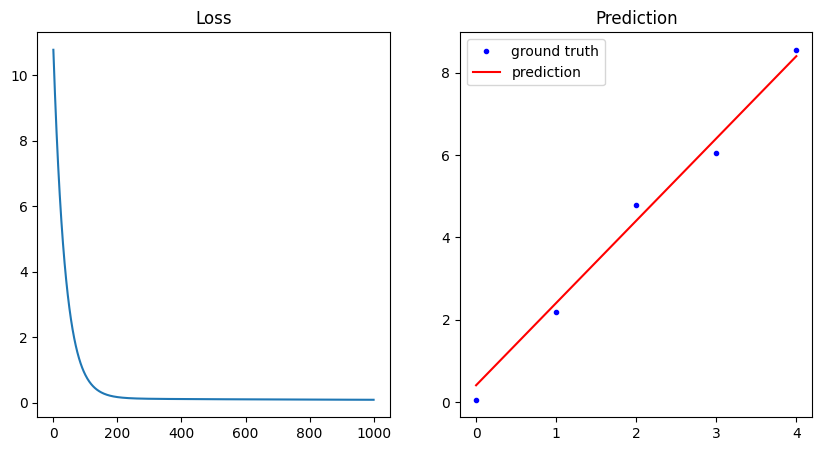

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x, y, '.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")
plt.show()

#### 2) 집값 예측하기

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('./data/reg.csv', index_col=[0])
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.028702,0.019528,0.455716,0.097575,0.576859,0.588769,0.654701,0.188444,0.007595,0.165409,0.736795,0.982923,0.219891,0.386667
502,0.034217,0.009498,0.490485,0.372934,0.532351,0.580505,0.750547,0.143776,0.051186,0.166428,0.867950,0.995114,0.207453,0.346667
503,0.035352,0.021495,0.423918,0.397988,0.349407,0.610529,0.907637,0.087385,0.083448,0.164870,0.782704,0.995791,0.094044,0.420000
504,0.026182,0.028603,0.443442,0.509663,0.229142,0.667841,0.867135,0.236241,0.016177,0.167554,0.749186,0.986855,0.107399,0.377778


In [14]:
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1, 1))

In [15]:
print(len(X)) # 첫번째 차원의 개수(행의 개수)
print(X.shape) # 전체 자료 구조 형태
print(X.size) # 전체 원소 개수

506
(506, 13)
6578


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

In [17]:
# tensor data 만들기 

class TensorData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    

trainsets = TensorData(X_train, Y_train)
trainloader = DataLoader(trainsets, batch_size=32, shuffle = True)
testsets = TensorData(X_test, Y_test)
testloader = DataLoader(testsets, batch_size = 32, shuffle=False)

In [18]:
# Model 구축하기

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)
        self.dropout = nn.Dropout(0.5) # 연산시마다 50% 확률로 노드를 없앤다. 출력층에서 사용하면 안된다. 중간층(은익층)에서 사용해야 한다. 

    def forward(self, x): # 활성화 함수 사용 유의 할 것
        x = F.relu(self.fc1(x)) 
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))

        return x

In [19]:
# Model 학습 설정

model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7) 
# weight_decay는 L2 정규화에서 penalty 값을 의미하며 값이 클수록 제약 조건이 강함을 의미 한다. 

In [20]:
# train

loss_ = []
n = len(trainloader)

for epoch in range(400):
    running_loss = 0.0
    for data in trainloader:
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_.append(running_loss/n)

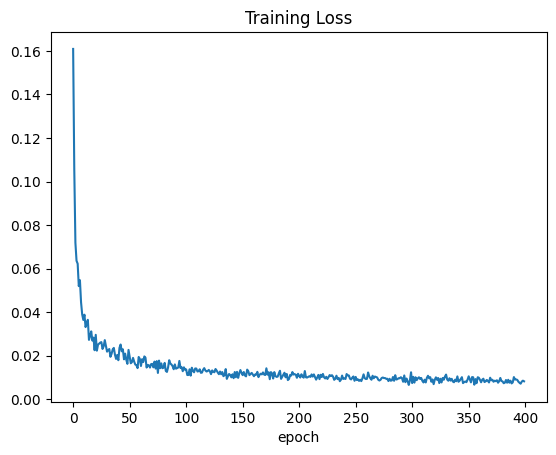

In [21]:
# 그래프 그리기

plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [22]:
# Model 평가하기

def evaluation(dataloader):

    predictions = torch.tensor([], dtype = torch.float) # 예측값과 그에 대응하는 실제값을 저장하기 위한 빈텐서 만들기
    actual = torch.tensor([], dtype = torch.float)

    with torch.no_grad():
        model.eval() # 드롭 아웃 같은 정규화 기법은 학습시에만 적용해야 한다. 따라서 모델에서 학습시에만 적용되는 층을 비활성화 하기 위해 eval()을 사용한다. 

        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs), 0) # torch.cat은 합친다는 의미 마지만 argument '0'는 첫번째 차원을 기준으로 concat한다는 뜻 10X2, 10X2면 20X2가 된다. 
            actual = torch.cat((actual, values), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))

    return rmse


In [23]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)
print("Train RMSE", train_rmse)
print("Test RMSE", test_rmse)

Train RMSE 0.0712039
Test RMSE 0.11082925


### (2) 활성화 함수

In [24]:
# 시그모이드 함수
# torch.sigmoid()  /  nn.Sigmoid()

# tanh 함수
# torch.tanh()  /  nn.Tanh()

# ReLU함수
# torch.nn.functional.relu()  / nn.ReLU()

# softmax 함수
# torch.nn.funtional.softmax()  /  nn.Softmax()

# 기타
# nn.ELU()  /  nn.LeakyReLU()  /  nn.LogSigmoid()  /  nn.SELU()

### (3) 손실함수

In [25]:
# MAE
# torch.nn.L1Loss

# MSE
# torch.nn.MSELoss

# Cross Entropy Loss
# torch.nn.CrossEntropyLoss

# 기타
# nn.BCELoss  /  nn.NLLoss  /  nn.KLDivLoss

### (4) 최적화 기법(optimizing, gradient descent) 

In [26]:
# SGD에 momentum지수 넣는 방법

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

# Adam optimizer 사용 방법

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001
                             )

#### 1) train sceduling
- epoch 혹은 iteration에 따른 학습률 조정을 위한 learnong rate scheduler를 optimizer 다음에 선언 할 수 있다. 이후 학습을 위한 for 문안에 scheduler.step()만 추가하면 자동으로 learning rate를 조절 할 수 있다. 

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)

for epoch in range(400):
    # break
    running_loss = 0.0
    for data in trainloader:
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        opimizer.step()

    scheduler.step()


# other scheduler
# MultiplicativeLR  /  LambdaLR  /  StepLR  /  MultiStepLR  /  ExponentiaLR / CosineAnnealingLR

NameError: name 'opimizer' is not defined

#### 2) MADGRAD
- 페이스북 연구팀이 발표한 새로운 최적화 기법

In [28]:
# 별도 설치 필요 pip install madgrad
import madgrad

In [29]:
optimizer = madgrad.MADGRAD(model.parameters())

### (5) 교차 검증
- k겹 교차 검증(k-Fold Cross-Validation) : 데이터를 k개로 나누어서 하나는 검증데이터로 사용하고, k-1개는 훈련데이터로 사용한다. k번 검증이 필요하기 때문에 느리지만 전체 데이터를 검증 데이터로 사용 할 수 있는 장접이 있다. 

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [34]:
# 데이터 준비
df = pd.read_csv('./data/reg.csv', index_col=[0])
X = df.drop('Price', axis = 1).to_numpy()
Y = df['Price'].to_numpy()

In [35]:
# Tensor data build
# trainset의 경우 교차 검증을 위해 미리 DataLoader를 정의 하지 않는다. 

class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
    

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7)
trainset = TensorData(X_train, Y_train)
testset = TensorData(X_test, Y_test)
# trainloader는 정의하지 않는다.
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [36]:
# Model Build

class Regressor(nn.Module):
    def __init__(self):
        supuer().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [39]:
# Define Loss function, Validation function 
kfold = KFold(n_splits=3, shuffle=True)
criterion = nn.MSELoss()

In [41]:
# Define evaluation function

def evaluation(dataloader):

    pridictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)

    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval()을 반드시 사용해 한다. 
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat통해 예측값 누적
            actual = torch.cat((actual, values), 0) # cat 통해 실제값 누적

    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    model.train() # 평가시에는 정규화 과정을 생략해야 하기 때문에 model.eval()사용한다. 다시 train모드로 바꾸기 위해 model.train()코드를 넣어준다. 
    return rmse

In [ ]:
# Evaluation by KFold Cross Validation

validation_loss = []

for fold, (train_idx, val_idx)